# Download Dataset

In [126]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [127]:
!pip install kaggle

In [134]:
!kaggle competitions download -c ashrae-energy-prediction
!unzip -u ashrae-energy-prediction.zip 

ashrae-energy-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ashrae-energy-prediction.zip


# Load data

In [136]:
PATH_BUILDING = "building_metadata.csv"
PATH_WEATHER = "weather_train.csv"
PATH_TRAIN = "train.csv"

In [137]:
building_df = pd.read_csv(PATH_BUILDING)
weather_train = pd.read_csv(PATH_WEATHER)
train = pd.read_csv(PATH_TRAIN)

train = train.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
train = train.merge(weather_train, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"])
del weather_train

# EDA

In [150]:
train.describe()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,wind_direction,weekday,hour,beaufort_scale
count,2.012560e+07,2.012560e+07,2.012560e+07,2.012560e+07,2.012560e+07,8.012299e+06,3.495553e+06,2.011944e+07,1.139074e+07,2.011596e+07,1.646708e+07,2.012560e+07,2.012560e+07,2.012560e+07,2.012560e+07
mean,7.972116e+02,6.617305e-01,7.967773e+00,3.159801e+00,1.103895e+01,6.834554e+01,4.175366e+00,1.598795e+01,1.900423e+00,7.747429e+00,7.964155e-01,1.735819e+02,3.007445e+00,1.151151e+01,2.313889e+00
std,4.263729e+02,9.310748e-01,5.092223e+00,3.451352e+00,1.181280e+00,3.020659e+01,3.992855e+00,1.094729e+01,2.402909e+00,1.017867e+01,7.468997e+00,1.107771e+02,1.996799e+00,6.923813e+00,1.300147e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.645447e+00,0.000000e+00,1.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.910000e+02,0.000000e+00,3.000000e+00,0.000000e+00,1.038983e+01,5.100000e+01,1.000000e+00,8.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+01,1.000000e+00,6.000000e+00,2.000000e+00
50%,8.940000e+02,0.000000e+00,9.000000e+00,1.000000e+00,1.119422e+01,7.000000e+01,3.000000e+00,1.670000e+01,0.000000e+00,8.900000e+00,0.000000e+00,1.800000e+02,3.000000e+00,1.200000e+01,2.000000e+00
75%,1.176000e+03,1.000000e+00,1.300000e+01,6.000000e+00,1.184304e+01,9.300000e+01,6.000000e+00,2.410000e+01,4.000000e+00,1.610000e+01,0.000000e+00,2.700000e+02,5.000000e+00,1.800000e+01,3.000000e+00
max,1.448000e+03,3.000000e+00,1.500000e+01,1.500000e+01,1.368198e+01,1.170000e+02,2.600000e+01,4.720000e+01,9.000000e+00,2.610000e+01,3.430000e+02,3.600000e+02,6.000000e+00,2.300000e+01,8.000000e+00


# Imputation

In [139]:
def average_imputation(df, column_name):
    imputation = df.groupby(['timestamp'])[column_name].mean()
    
    df.loc[df[column_name].isnull(), column_name] = df[df[column_name].isnull()][[column_name]].apply(lambda x: imputation[df['timestamp'][x.index]].values)
    del imputation
    return df


In [140]:
train = average_imputation(train, 'wind_speed')
train = average_imputation(train, 'wind_direction')

In [141]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["weekday"] = train["timestamp"].dt.weekday
train["hour"] = train["timestamp"].dt.hour
train["weekday"] = train['weekday'].astype(np.uint8)
train["hour"] = train['hour'].astype(np.uint8)
train['year_built'] = train['year_built']-1900
train['square_feet'] = np.log(train['square_feet'])

# Feature Engineering

In [142]:
beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    train.loc[(train['wind_speed']>=item[1]) & (train['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

In [143]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train["primary_use"] = le.fit_transform(train["primary_use"])

categoricals = ["site_id", "building_id", "primary_use", "hour", "weekday", "meter",  "wind_direction"]

In [144]:
drop_cols = ["sea_level_pressure", "wind_speed"]

numericals = ["square_feet", "year_built", "air_temperature", "cloud_coverage",
              "dew_temperature", 'precip_depth_1_hr', 'floor_count', 'beaufort_scale']

feat_cols = categoricals + numericals

In [145]:
target = np.log1p(train["meter_reading"])

del train["meter_reading"] 

train = train.drop(drop_cols, axis = 1)

In [146]:
del train["timestamp"]

# Model

In [147]:
train.shape, target.shape

((20125605, 15), (20125605,))

In [162]:
X = train.loc[0:10000, :].values
Y = target[0:10001].values

In [163]:
X.shape, Y.shape

((10001, 15), (10001,))

(array([1.911e+03, 1.524e+03, 2.885e+03, 2.292e+03, 9.420e+02, 3.800e+02,
        4.300e+01, 2.100e+01, 1.000e+00, 2.000e+00]),
 array([ 0.        ,  1.49915872,  2.99831743,  4.49747615,  5.99663486,
         7.49579358,  8.99495229, 10.49411101, 11.99326972, 13.49242844,
        14.99158716]),
 <a list of 10 Patch objects>)

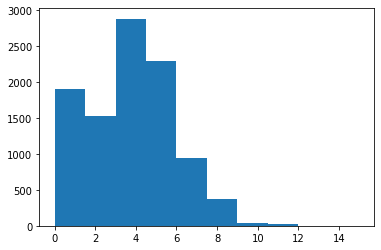

In [164]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Y)

In [165]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

clf = DummyRegressor()
scores = cross_val_score(clf, X, Y, scoring="neg_mean_squared_error", cv=5)
np.mean(scores), np.std(scores)

(-5.053901888953941, 0.29510354251769016)

In [166]:
from tpot import TPOTRegressor
tpot_obj = TPOTRegressor(generations=5, population_size=10, config_dict='TPOT light', verbosity=2)

In [167]:
tpot_obj.fit(X, Y)

Imputing missing values in feature set


Generation 1 - Current best internal CV score: -1.505043786113452
Generation 2 - Current best internal CV score: -1.328276902541433
Generation 3 - Current best internal CV score: -1.328276902541433
Generation 4 - Current best internal CV score: -1.328276902541433
Generation 5 - Current best internal CV score: -1.328276902541433

Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=10, min_samples_leaf=5, min_samples_split=2)


TPOTRegressor(config_dict='TPOT light', crossover_rate=0.1, cv=5,
              disable_update_check=False, early_stop=None, generations=5,
              max_eval_time_mins=5, max_time_mins=None, memory=None,
              mutation_rate=0.9, n_jobs=1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=10,
              random_state=None, scoring=None, subsample=1.0, template=None,
              use_dask=False, verbosity=2, warm_start=False)

In [175]:
import lightgbm as lgb

OSError: dlopen(/Users/nostrum/anaconda3/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /Users/nostrum/anaconda3/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

# Predict

In [168]:
test = pd.read_csv("test.csv")
test = test.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
del building_df
test["primary_use"] = le.transform(test["primary_use"])
weather_test = pd.read_csv("weather_test.csv")
test = test.merge(weather_test, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"], how = "left")
del weather_test

In [169]:
test["timestamp"] = pd.to_datetime(test["timestamp"])
test["hour"] = test["timestamp"].dt.hour
test["weekday"] = test["timestamp"].dt.weekday
test["weekday"] = test['weekday'].astype(np.uint8)
test["hour"] = test['hour'].astype(np.uint8)
test['year_built'] = test['year_built']-1900
test['square_feet'] = np.log(test['square_feet'])

test = average_imputation(test, 'wind_speed')
test = average_imputation(test, 'wind_direction')

for item in beaufort:
    test.loc[(test['wind_speed']>=item[1]) & (test['wind_speed']<item[2]), 'beaufort_scale'] = item[0]
test['beaufort_scale'] = test['beaufort_scale'].astype(np.uint8)
test["wind_direction"] = test['wind_direction'].astype(np.uint8)
test["meter"] = test['meter'].astype(np.uint8)
test["site_id"] = test['site_id'].astype(np.uint8)

test = test[feat_cols]

In [170]:
test.shape

(41697600, 15)

In [171]:
X_test = test.values

In [172]:
prediction = tpot_obj.predict(X_test)

Imputing missing values in feature set


(array([ 5863605.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0., 35833995.]),
 array([0.        , 0.370937  , 0.741874  , 1.11281101, 1.48374801,
        1.85468501, 2.22562201, 2.59655902, 2.96749602, 3.33843302,
        3.70937002]),
 <a list of 10 Patch objects>)

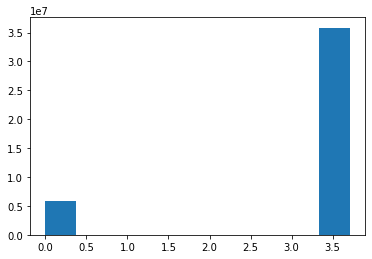

In [173]:
plt.hist(prediction)

# Submission

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['meter_reading'] = prediction
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0
submission.to_csv('submission_first_tpot.csv', index=False)
submission

In [116]:
target.values.tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.9934131126433927,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.784219178936348,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.978196439367148,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.1906244875217977,
 0.31816277970536777,
 0.0,
 5.17152890347659,
 4.524668122826975,
 4.4058652241537235,
 0.0,
 4.468528819547206,
 5.126294594741541,
 2.422570146872214,
 4.5847429636730475,
 5.079184511627788,
 3.0251454341223405,
 5.786130216004954,
 4.61512051684126,
 5.310952209683453,
 4.252771798816619,
 2.851059040510624,
 3.